In [3]:
!pip install fuzzywuzzy

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [4]:
from __future__ import unicode_literals, print_function, division
import pandas as pd
import numpy as np
import statistics
import re
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import string
from nltk import word_tokenize
from nltk.translate.bleu_score import sentence_bleu
import re
from tqdm import tqdm

from io import open
import unicodedata
import re
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.switch_backend('agg')
import time
import math
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

if(torch.cuda.is_available()): 
    print("GPU")
    device = torch.device("cuda")
else: 
    print("CPU")
    device = torch.device("cpu")

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


GPU


In [5]:
df_train = pd.read_csv(open('data_train.csv', 'rb'))
df_test = pd.read_csv(open('data_test.csv', 'rb'))
#filter out mappings with no change
df_train_filtered = df_train[df_train['Similarity'] != 1.00]
df_test_filtered = df_test[df_test['Similarity'] != 1.00]
print(f'Training size: {len(df_train_filtered)}\nTest size: {len(df_test_filtered)}')

Training size: 9465
Test size: 1677


In [6]:
#extract source and target data and cast to string
source_train = df_train_filtered.loc[:, 'S L1':'Source Description'].astype(str).reset_index(drop=True)
target_train = df_train_filtered.loc[:, 'T L1':'Target Description'].astype(str).reset_index(drop=True)

source_test = df_test_filtered.loc[:, 'S L1':'Source Description'].astype(str).reset_index(drop=True)
target_test = df_test_filtered.loc[:, 'T L1':'Target Description'].astype(str).reset_index(drop=True)

source_train.head(3)

,S L1,S L2,S L3,S L4,S L5,S L6,S L7,S L8,S L9,S L10,Source Description
0,M003 Mars Financial Statement V2 (Full Trial B...,Profit and Loss,43. Non Operating,Non Operating Costs,nan,nan,nan,nan,nan,nan,Non-Operating Costs - Project 8
1,MFPS Balance Sheet (MARS FPPS structure),PROFIT & LOSS STATEMENT,Income before Income Taxes,Operating Profit,Margin after Conversion,Cost of Manufactured Goods Sold,Other Cost of Sales,Factory Variances & costs,nan,nan,Revaluation of Semi-Fin.Products Inv.(SAP post...
2,MFPS Balance Sheet (MARS FPPS structure),2926 NET OPERATING ASSETS Assets,2912 Total Operating Assets,2893 Gross Operating Assets,2875 Current Operating Assets,2336 Other Current,2332 Prepaid Exp/Def Charges,Prepayments & Other Current AR,nan,nan,Prepayments Equipment Rental


In [7]:
target_train.head(3)

,T L1,T L2,T L3,T L4,Target Description
0,Operating Expenses,Other Operating Expenses,For Future Use - Other Operating Expenses,nan,Other Operating - Project 8
1,Cost of Sales,Cost of Manufactured Goods,Inventory Changes,Inventory Value Changes,Inventory Adjust - Price Revaluation-SemiFin G...
2,Assets,Prepaid Expenses and Other Current Assets,Prepaid Expenses,Prepaid Expenses,Prepayments - General & Administrative


In [278]:
#helper functions

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def plot_loss(losses, n_iters, benchmark_every):
    
    %matplotlib inline
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    x = np.arange(0, n_iters, benchmark_every)
    y = losses
    ax.plot(x, y)
    ax.set_title('Training Loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Iteration')
    plt.show()

In [294]:
def preprocess_text(text):

    text = text.lower().strip()
    text = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('\\s+', ' ', text)

    return text

def process_hierarchy_string(df, row_idx, num_levels, level_prefix, delimiter=' '):

    hierarchy = []
    for l in range(num_levels):
        level_label = level_prefix+str(l+1)
        level_text = df.loc[row_idx, level_label]
        #if level_text == 'nan': continue
        #else: 
        level_text = preprocess_text(level_text)
        hierarchy.append(level_text)

    hierarchy_string = delimiter.join(hierarchy)
    
    return hierarchy_string 

process_hierarchy_string(source_train, row_idx=0, num_levels=10, level_prefix = 'S L')

'm003 mars financial statement v2 full trial balan profit and loss 43 non operating non operating costs nan nan nan nan nan nan'

In [295]:
SOS_token = 0
EOS_token = 1

class Vocabulary:

    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "UNKNOWN"}
        self.n_words = 3  # Count SOS, EOS, UNKNOWN

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [296]:
def create_pairs(x_data, y_data, source_length ='short', target_length='short', hierarchy_delimiter=' '):

    x_data = x_data.reset_index(drop=True)
    y_data = y_data.reset_index(drop=True)

    sources, targets = [], []

    for i in range(len(x_data)):
        source_hierarchy = process_hierarchy_string(x_data, row_idx=i, num_levels=10, level_prefix = 'S L', delimiter=hierarchy_delimiter)
        target_hierarchy = process_hierarchy_string(y_data, row_idx=i, num_levels=4, level_prefix = 'T L', delimiter=hierarchy_delimiter)

        source_description = preprocess_text(x_data.loc[i, 'Source Description'])
        target_description = preprocess_text(y_data.loc[i, 'Target Description'])

        if source_length == 'short':
            source_text = source_description
        elif source_length == 'long':
            source_text = source_hierarchy + hierarchy_delimiter + source_description
        else:
            print("Error: unrecognized input for source_length, try 'short' or 'long'")
            return 0

        if target_length == 'short':
            target_text = target_description  
        elif target_length == 'long':
            target_text = target_hierarchy + hierarchy_delimiter + target_description
        else:
            print("Error: unrecognized input for target_length, try 'short' or 'long'")
            return 0

        sources.append(source_text)
        targets.append(target_text)

    pairs = list((zip(sources, targets)))
    
    return pairs

def create_vocabulary(set1, set2, x_data, y_data, source_length='short', target_length='short', hierarchy_delimiter=' '):

    input_set = Vocabulary(set1)
    output_set = Vocabulary(set2)

    pairs = create_pairs(x_data, y_data, source_length, target_length, hierarchy_delimiter)

    print("%s pairs" % len(pairs))
    for pair in pairs:
        input_set.add_sentence(pair[0])
        output_set.add_sentence(pair[1])

    print("Vocabulary:")
    print(f'\t{input_set.name}: {input_set.n_words}')
    print(f'\t{output_set.name}: {output_set.n_words}')

    return input_set, output_set, pairs

In [297]:
MAX_LENGTH = 100

class Encoder(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


class Decoder(nn.Module):

    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.name = 'Decoder'
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


class AttnDecoder(nn.Module):

    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoder, self).__init__()
        self.name = 'AttnDecoder'
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [298]:
def indexes_from_sentence(set, sentence):
    sentence_indexes = []
    unknown_word = None
    for word in sentence.split(' '):
        if word not in set.word2index:
            sentence_indexes.append(2)
            unknown_word = word
        else:
            sentence_indexes.append(set.word2index[word])
            
    return sentence_indexes, unknown_word


def tensor_from_sentence(set, sentence):

    indexes, unknown_word = indexes_from_sentence(set, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1), unknown_word


def tensors_from_pair(pair, input_set, output_set):

    input_tensor, unknown_word_input = tensor_from_sentence(input_set, pair[0])
    target_tensor, unknown_word_target = tensor_from_sentence(output_set, pair[1])
    return (input_tensor, target_tensor), unknown_word_input, unknown_word_target

In [299]:
teacher_forcing_ratio = 0.0

def run_iter(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):

    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    loss = 0

    for en in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[en], encoder_hidden)
        encoder_outputs[en] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for de in range(target_length):
            if(decoder.name == 'AttnDecoder'):
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
            else:
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                
            loss += criterion(decoder_output, target_tensor[de])
            decoder_input = target_tensor[de]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for de in range(target_length):
            if(decoder.name == 'AttnDecoder'):
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
            else:
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[de])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [300]:
def train_model(input_set, output_set, encoder, decoder, pairs, n_iters, benchmark_every = 100, learning_rate=0.01):

    print('Training model...')
    loss_total = 0  # Reset every benchmark_every
    losses = []

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensors_from_pair(random.choice(pairs), input_set, output_set)[0] for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for i in tqdm(range(1, n_iters + 1)):
        training_pair = training_pairs[i - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = run_iter(input_tensor, target_tensor, encoder,
                        decoder, encoder_optimizer, decoder_optimizer, criterion)
        
        loss_total += loss
        
        if i % benchmark_every == 0:
            loss_avg = loss_total / benchmark_every
            losses.append(loss_avg)
            loss_total = 0
    
    plot_loss(losses, n_iters, benchmark_every)
    print(f'Final loss: {losses[-1]}')
    
    

In [301]:
def evaluate(input_set, output_set, encoder, decoder, sentence, max_length=MAX_LENGTH):
    
    with torch.no_grad():
        input_tensor, unknown_word = tensor_from_sentence(input_set, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for en in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[en], encoder_hidden)
            encoder_outputs[en] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for de in range(max_length):
            if(decoder.name == 'AttnDecoder'):
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                    
                decoder_attentions[de] = decoder_attention.data

            else:
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            
            topv, topi = decoder_output.data.topk(1)

            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_set.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:de + 1], unknown_word


def print_predictions_on_test(input_set, output_set, encoder, decoder, sources, targets, n=10, source_length='short', target_length='short', hierarchy_delimiter=' '):
    for i in range(n):
        pairs = create_pairs(sources, targets, source_length, target_length, hierarchy_delimiter)
        pair = random.choice(pairs)
        print(f'SOURCE: {pair[0]}')
        print(f'TARGET: {pair[1]}')
        output_words, _, unknown_word = evaluate(input_set, output_set, encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        if unknown_word != None:
            print(f'UNKNOWN WORD: {unknown_word}')
        print(f'PREDICTION: {output_sentence} \n')


def eval_on_test(input_set, output_set, encoder, decoder, sources, targets, source_length='short', target_length='short', hierarchy_delimiter=' '):

    prediction_similarities_to_targets = []
    pairs = create_pairs(sources, targets, source_length, target_length, hierarchy_delimiter)
    score = 0
    max_score = len(pairs)
    bleu_scores = []
    unknown_words = []

    for pair in pairs:
        target = pair[1]
        output_words, _, unknown_word = evaluate(input_set, output_set, encoder, decoder, pair[0])
        prediction = ' '.join(output_words[:-1])

        target_words = [target.split(' ')]
        prediction_words = prediction.split(' ')
        bleu_score = round(sentence_bleu(target_words, prediction_words, weights=(1,)), 7)
        bleu_scores.append(bleu_score)
        
        if prediction == target: score += 1
        if unknown_word != None: unknown_words.append(unknown_word)

        pred_similarity = fuzz.token_sort_ratio(target, prediction)/100
        prediction_similarities_to_targets.append(pred_similarity)

    match_accuracy = score/max_score    
    avg_pred_similarity_to_target = np.mean(prediction_similarities_to_targets)
    unique_unknowns = set(unknown_words)

    print(f'Bleu score average: {np.mean(bleu_scores):.2f} \
            \nprediction exact match accuracy: {match_accuracy*100:.2f}% \
            \naverage prediction similarity to target: {avg_pred_similarity_to_target*100:.2f}% \
            \nunknown words found: {len(unique_unknowns)}/{max_score}')

    return match_accuracy, avg_pred_similarity_to_target, unique_unknowns

In [306]:
input_set, output_set, pairs = create_vocabulary('legacy', 'new', source_train, target_train, source_length = 'long', target_length = 'long')
print(random.choice(pairs))

9465 pairs
Vocabulary:
	legacy: 4862
	new: 1749
('mfps balance sheet mars fpps structure 2926 net operating assets assets 2925 total operating liabilities 2923 current operating liabilities 36041 med term incentive plan cur nan nan nan nan nan msop plus liabilities current', 'liabilities accounts payable accrued liabilities accrued salaries wages benefits bonuses and payroll taxes accrued incentive plans long term incentive plans current')


Training model...


100%|██████████| 10000/10000 [06:56<00:00, 23.99it/s]


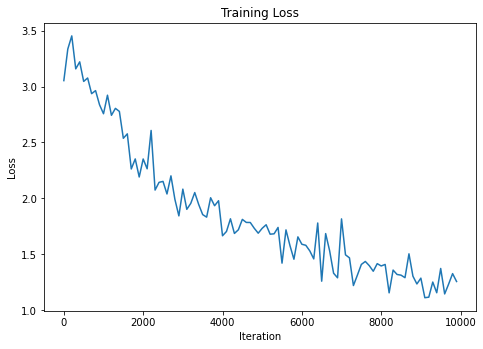

Final loss: 1.2562967498200144


In [307]:
hidden_size = 256
encoder1 = Encoder(input_set.n_words, hidden_size).to(device)
decoder1 = Decoder(hidden_size, output_set.n_words).to(device)

train_model(input_set, output_set, encoder1, decoder1, pairs, n_iters = 10000)

In [308]:
results = eval_on_test(input_set, output_set, encoder1, decoder1, source_test, target_test, source_length='long', target_length='long')

Bleu score average: 0.69             
prediction exact match accuracy: 15.09%             
average prediction similarity to target: 78.67%             
unknown words found: 323/1677


In [309]:
print_predictions_on_test(input_set, output_set, encoder1, decoder1, source_test, target_test, n=5, source_length='long', target_length='long')

SOURCE: m003 mars financial statement v2 full trial balan 72 net financing 43 total treasury assets 35 deposits with cash center 125 deposits with cash center nan nan nan nan nan bank deposit with cash centre 18 temp for v2
TARGET: assets cash investments internal bank accounts deposits with cash center bank depositborrowing with cash center
PREDICTION: assets cash investments internal bank accounts deposits with cash center bank depositborrowing with cash center <EOS> 

SOURCE: m003 mars financial statement v2 full trial balan profit and loss operating profit general admin costs overheads fixed costs office costs nan nan nan nan building rental nontax deductible
TARGET: operating expenses operating expenses general administrative expenses facilities property rent non taxdeductible
PREDICTION: operating expenses operating expenses general administrative expenses travel relations and <EOS> 

SOURCE: liabilities noncurrent liabilities intercompany payable nan nan nan nan nan nan nan ap l

Training model...


100%|██████████| 10000/10000 [09:12<00:00, 18.09it/s]


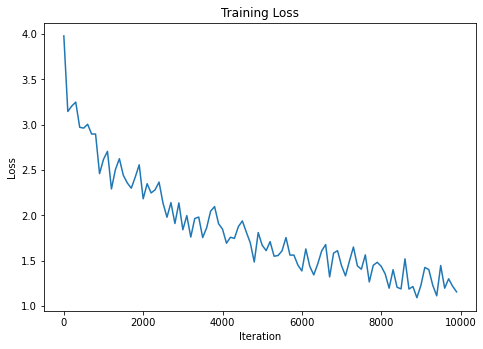

Final loss: 1.1553346737828105


In [78]:
hidden_size = 256
encoder2 = Encoder(input_set.n_words, hidden_size).to(device)
decoder2 = AttnDecoder(hidden_size, output_set.n_words).to(device)

train_model(input_set, output_set, encoder2, decoder2, pairs, n_iters = 10000)

In [79]:
results = eval_on_test(input_set, output_set, encoder2, decoder2, source_test, target_test, source_length='long', target_length='long')

Bleu score average: 0.69             
prediction exact match accuracy: 14.97%             
average prediction similarity to target: 77.79%             
unknown words found: 323/1677


Training model...


100%|██████████| 50000/50000 [49:17<00:00, 16.91it/s]


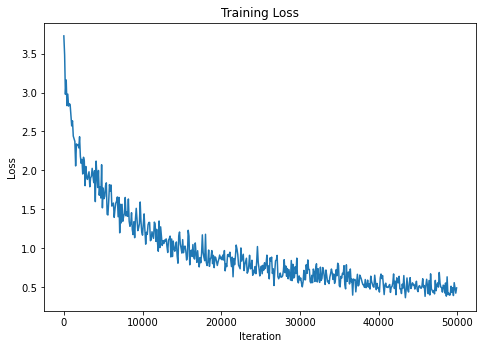

Final loss: 0.49220491377473247


In [ ]:
hidden_size = 256
encoder3 = Encoder(input_set.n_words, hidden_size).to(device)
decoder3 = AttnDecoder(hidden_size, output_set.n_words).to(device)

train_model(input_set, output_set, encoder3, decoder3, pairs, n_iters = 50000)

In [81]:
results = eval_on_test(input_set, output_set, encoder3, decoder3, source_test, target_test, source_length='long', target_length='long')

Bleu score average: 0.81             
prediction exact match accuracy: 37.98%             
average prediction similarity to target: 87.08%             
unknown words found: 323/1677


In [83]:
print_predictions_on_test(input_set, output_set, encoder3, decoder3, source_test, target_test, n=5, source_length='long', target_length='long')

SOURCE: m003 mars financial statement v2 full trial balan 31 net operating assets 18 total operating assets 12 gross operating assets 8 current operating assets 4 accounts receivable brokers 137 accounts receivable brokers open rec currency contracts with currency center
TARGET: assets prepaid expenses and other current assets other assets current other assets current fair value of treasury derivatives current
PREDICTION: assets accounts receivable accounts receivable commodity assets commodity brokers commodity taxes manual <EOS> 

SOURCE: m003 mars financial statement v2 full trial balan profit and loss operating profit 9 total prime costs inventory valuation adjustment value of production value of production of sub processed raws
TARGET: cost of sales cost of manufactured goods inventory changes value of production value of production subprocessed raws
UNKNOWN WORD: processed
PREDICTION: cost of sales cost of manufactured goods inventory changes inventory value production production

In [43]:
## Delimited hierarchy strings

In [310]:
input_set_dl, output_set_dl, pairs_dl = create_vocabulary('legacy', 'new', source_train, target_train, source_length = 'long', target_length = 'long', hierarchy_delimiter=' > ')
print(random.choice(pairs_dl))

9465 pairs
Vocabulary:
	legacy: 4863
	new: 1750
('m003 mars financial statement v2 full trial balan > non corporate accounts > profit and loss > nan > nan > nan > nan > nan > nan > nan > legal analytical ledger 71', 'statutory future use > statutory nonoperating expenses taxes > statutory nonoperating expenses taxes > statutory statistical accounts > analytical ledger revenueexpense legal adjust')


Training model...


100%|██████████| 10000/10000 [09:19<00:00, 17.86it/s]


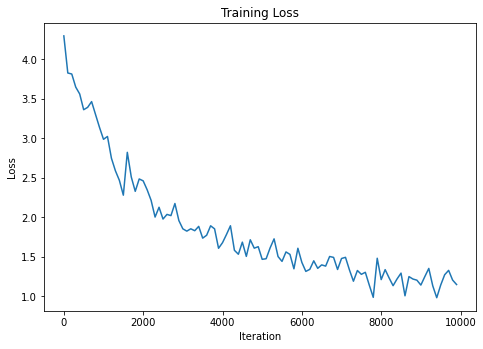

Final loss: 1.1484356345481914


In [311]:
hidden_size = 256
encoder_dl = Encoder(input_set_dl.n_words, hidden_size).to(device)
decoder_dl = Decoder(hidden_size, output_set_dl.n_words).to(device)

train_model(input_set_dl, output_set_dl, encoder_dl, decoder_dl, pairs_dl, n_iters = 10000)

In [312]:
pairs_dl_test = create_pairs(source_test, target_test, source_length='long', target_length='long', hierarchy_delimiter=' > ')
pairs_dl_test[4][1]

'assets > current assets > accounts receivable > nan > accounts receivable pcca e2'

In [313]:
def calc_hierarchy_level_scores(pair, print_scores=False):
    
    bleu_scores = []
    target = pair[1]
    target_levels = target.split(' > ')
    target_description = target_levels.pop()
    
    output_words, _, unknown_word = evaluate(input_set_dl, output_set_dl, encoder_dl, decoder_dl, pair[0])
    prediction = ' '.join(output_words[:-1])
    prediction_levels = prediction.split(' > ')
    #seperate description incase predict less levels than target
    prediction_description = prediction_levels.pop()
    
    #if prediction is shorter than target, pad prediction levels with nan
    if len(prediction_levels) < len(target_levels):
        level_diff = len(target_levels) - len(prediction_levels)
        for i in range(level_diff):
            prediction_levels.append('nan')
    
    for i in range(len(target_levels)):
        target_level = target_levels[i]
        predict_level = prediction_levels[i]
        #if(predict_level == '>'): predict_level='nan'

        target_level_words = [target_level.split(' ')]
        predict_level_words = predict_level.split(' ')
        level_bleu_score = round(sentence_bleu(target_level_words, predict_level_words, weights=(1,)), 7)
        bleu_scores.append(level_bleu_score)
        
        if(print_scores): print(f"{target_level} - {predict_level} - {level_bleu_score}")
            
    target_description_words = [target_description.split(' ')]
    predict_description_words = prediction_description.split(' ')
    description_bleu_score = round(sentence_bleu(target_description_words, predict_description_words, weights=(1,)), 7)
    bleu_scores.append(description_bleu_score)
    
    if(print_scores): print(f"{target_description} - {prediction_description} - {description_bleu_score}")
        
    target = target_levels + [target_description]
    prediction = prediction_levels + [prediction_description]
    
    return bleu_scores, target, prediction
        
    

In [314]:
t = 5
print_scores = calc_hierarchy_level_scores(pairs_dl_test[t], print_scores=True)

assets - assets - 1.0
cash investments - cash investments - 1.0
cash - cash - 1.0
external bank accounts foreign noninterest bearing - external bank accounts foreign noninterest bearing - 1.0
bank account in foreign currency 14 - bank foreign in checks currency - 0.6549846


In [315]:
def calc_level_scores_and_avg(pairs):

    T_list, P_list = [], []
    bleu_scores = []
    bleu_scores_TL1 = []
    bleu_scores_TL2 = []
    bleu_scores_TL3 = []
    bleu_scores_TL4 = []
    bleu_scores_description = []
    score_avg_across_levels =[]
    
    for t in tqdm(range(len(pairs))):
        pair = pairs[t]
        level_scores, target_hierarchy, predict_hierarchy=calc_hierarchy_level_scores(pair)
        
        bleu_scores.append(level_scores)
        T_list.append(target_hierarchy)             
        P_list.append(predict_hierarchy)

        bleu_scores_TL1.append(level_scores[0])
        bleu_scores_TL2.append(level_scores[1])
        bleu_scores_TL3.append(level_scores[2])
        bleu_scores_TL4.append(level_scores[3])
        bleu_scores_description.append(level_scores[4])
        
    score_avg_across_levels.append(statistics.mean(bleu_scores_TL1))
    score_avg_across_levels.append(statistics.mean(bleu_scores_TL2))
    score_avg_across_levels.append(statistics.mean(bleu_scores_TL3))
    score_avg_across_levels.append(statistics.mean(bleu_scores_TL4))
    score_avg_across_levels.append(statistics.mean(bleu_scores_description))
    
    return T_list, P_list, bleu_scores, score_avg_across_levels


In [316]:
def create_results_df(pairs):
    
    targets, predictions, scores, score_avg_across_levels = calc_level_scores_and_avg(pairs)
    results_zipped = list(zip(targets, predictions, scores))

    df_results = pd.DataFrame()

    for i in tqdm(range(len(targets))):
        tar, pred, scores = results_zipped[i]

        df_results = df_results.append({'T L1': tar[0], 'P L1': pred[0], 'Score - L1': scores[0],
                                        'T L2': tar[1], 'P L2': pred[1], 'Score - L2': scores[1],
                                        'T L3': tar[2], 'P L3': pred[2], 'Score - L3': scores[2],
                                        'T L4': tar[3], 'P L4': pred[3], 'Score - L4': scores[3],
                                        'T Description': tar[4], 'P Description': pred[4], 'Score - Description': scores[4]
                                       }, ignore_index=True)
        
    df_results = df_results.reindex(columns=['T L1', 'P L1', 'Score - L1', 'T L2', 'P L2', 'Score - L2',
                                             'T L3', 'P L3', 'Score - L3', 'T L4', 'P L4', 'Score - L4',
                                             'T Description', 'P Description', 'Score - Description'
                                            ])
                  
    return df_results, score_avg_across_levels

df_results, level_score_avgs = create_results_df(pairs_dl_test)

100%|██████████| 1677/1677 [00:14<00:00, 118.80it/s]


In [317]:
df_results.head(5)

,T L1,P L1,Score - L1,T L2,P L2,Score - L2,T L3,P L3,Score - L3,T L4,P L4,Score - L4,T Description,P Description,Score - Description
0,cash and cash equivalents,assets,0.0,nan,cash investments,0.0,nan,cash,0.0,nan,external on,0.000000,cash clearing legacy ns,nan,0.000000
1,below operational secondary management and tec...,statutory future use,0.0,ledgerdata takeon,inventory,0.0,takeon accounts,inventory,0.0,data takeon accounts,accounts,0.135335,semifinished goods data takeon,> goods,0.000000
2,assets,assets,1.0,current assets,current assets,1.0,accounts receivable,accounts receivable,1.0,nan,nan,1.000000,accounts receivable trade,accounts receivable trade,1.000000
3,statutory future use,statutory future use,1.0,statutory current and noncurrent assets,statutory current and noncurrent assets,1.0,statutory current and noncurrent assets,statutory current and noncurrent assets,1.0,statutory property plant and equipment at cost,statutory property plant and equipment at cost,1.000000,historic value machinery equipment legal adj,historic value machinery equipment legal adj,1.000000
4,assets,assets,1.0,current assets,current assets,1.0,accounts receivable,accounts receivable,1.0,nan,nan,1.000000,accounts receivable pcca e2,accounts receivable trade,0.477687


In [318]:
level_score_avgs

[0.9107558162790698,
 0.8318961207513417,
 0.6901965872391175,
 0.6242132751937984,
 0.3754807967799642]